## Здравствуйте, меня зовут *Дарья Петренко*, вот моё Задание №4 по курсу ПСАД-2020!

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

from math import sqrt, factorial
from itertools import chain, permutations
from random import shuffle


import seaborn as sns
sns.set()

np.random.seed(228)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

## Задача 1  

Задана обучающая выборка $\widetilde{S}$ размера $n \times 2$, включающая значения переменных $X$ и $Y$.

In [380]:
from scipy.stats import linregress

def draw_linear(x, y, x_name='X', y_name='Y'):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_max, x_min = x.max(), x.min()
    x_range = x_max - x_min
    x_lims = np.array([x_min - 0.1 * x_range, x_max + 0.1 * x_range])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

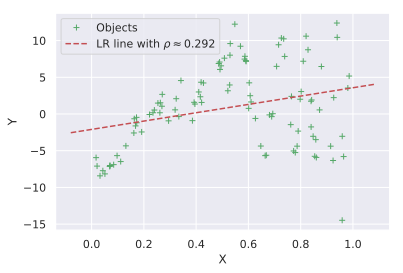

In [381]:
S = np.load("data1.npy")
X, Y = S
draw_linear(X, Y)

* Оцените значимость коэффициента корреляции с помощью трёх тестов: критерия Стюдента, перестановочного теста и бутстреп-критерия. Под значимостью коэффициента в данном случае понимается его значимое отличие от нуля.

* Постройте графики нулевых распределений перестановочного и t-теста, а также распределение статистики бутстреп-теста. Попробуйте использовать функции `sns.lineplot, sns.distplot`. Для параметрического распределения носитель нужно определять самому, а для непараметрического можно рисовать гистограмму по данным как есть.

* Сравните полученные результаты и напишите выводы.

In [120]:
from scipy.stats import t, norm, kstwobign

### Критерий Стьюдента

Проведите **двусторонний t-тест** для нулевой гипотезы о равенстве корреляции нулю. Для этого воспользуйтесь центральной предельной теоремой, приведя статистику к стандартизованной форме распределения Стьюдента . Полученное распределение $St(n - 2)$ будет **распределением нулевой гипотезы** $H_0$, а посчитанная статистика $T(X, Y)$ -- **его квантилью**. Достигаемый уровень значимости -- это вероятностная масса нулевого распределения, на которой суммарно получилось такое же или ещё более экстремальное значение статистики. В случае двустороннего теста заранее неизвестно, по какую сторону от нуля будет значение статистики, поэтому учитываются оба варианта.

In [28]:
def pearson_corr(X, Y):
    n = X.shape[0]
    X_mean = X.mean()
    Y_mean = Y.mean()
    r = np.mean((X - X_mean) * (Y - Y_mean)) / np.sqrt(np.mean((X - X_mean) ** 2) * np.mean((Y - Y_mean) ** 2))
    
    return r

In [60]:
def student_significance(X, Y):
    n = X.shape[0]
    r = pearson_corr(X, Y)
    T = r * np.sqrt(n - 2) / np.sqrt(1 - r ** 2)
    p_val = 2 * (1 - t.cdf(T, n - 2))
    return T, p_val

### Перестановочный тест

Проведите **двусторонний перестановочный тест** для нулевой гипотезы о равенстве корреляции нулю. Нулевое распределение порождается перебором $n!$ перестановок индексов одной из выборок. Достигаемый уровень значимости -- доля перестановок, на которых получилось такое же или ещё более экстремальное значение статистики. Перебор всех перестановок может быть очень большим, поэтому ограничиваются случайным подмножеством перестановок. В силу симметрии распределения, двусторонний тест учитывает абсолютное значение статистики. 

**Замечание**. Похоже, это очень непросто для создателей библиотек реализовать функцию перестановки, чтобы она возвращала _случайное подмножество_ перестановок. Функция `itertools.permutations` возвращает все возможные _упорядоченные_ перестановки, причём их невозможно перемешать или взять подвыборку, не раскрывая генератор. Функция `np.random.permutation` выполняет одну случайную перестановку, вот её как раз и можно записать в цикле.

In [59]:
def permutation_test_significance(X, Y, n_permutations=100000):
    n = X.shape[0]
    r = pearson_corr(X, Y)
    perm_distr = []
    for i in range(n_permutations):
        ind_array = np.random.permutation(np.arange(n))
        perm_distr.append(pearson_corr(X[ind_array], Y))
    perm_distr = np.array(perm_distr)
    p_val = np.mean(np.abs(perm_distr) >= np.abs(r))
    return perm_distr, p_val

### Бутстреп

Примените **двусторонний бутстреп-тест** о равенстве корреляции нулю. В бутстреп-тесте не строится распределение нулевой гипотезы, а вместо этого напрямую строится приближённое **распределение исследуемой статистики**. В оценке корреляции участвуют две выборки $X, Y$, поэтому для создания на их основе псевдовыборок методом Монте-Карло, мы сэмплируем с возвращением пары $(X_i, Y_i)$ и, считая корреляцию внутри каждой псевдовыборки, получаем бутстреп-распределение корреляции. 

Дальше по вычисленному бутстреп-распределению статистики нужно оценить **достигаемый уровень значимости (_p-value_)** критерия. Сначала построим два односторонних критерия. В них достигаемый уровень значимости -- это доля псевдовыборок, на которых корреляция меньше либо равно нулю (больше либо равна нулю). Дальше остаётся взять минимальное значение двух критериев (оно будет соответствовать тому, в какую сторону корреляция исходной выборки отклоняется от нуля) и умножить это значение на два (тем самым мы комбинаторно учитываем оба случая). Полученное значение и будет значением _p-value_ двустороннего бутстреп-критерия.

**Замечание**. Тоже относится к многомерному `np.random.choice` для случайного выбора пары точек. Но, похоже, что и его непросто реализовать, и у нас есть только одномерный вариант функции, который вполне успешно выполняется в цикле.

В последних версиях библиотеки добавили `np.random.Generator.choice` и `np.random.Generator.permutation`, в которых присутствует `axis`, позволяющий векторизовать многомерные операции. Если только вам будет интересно с этим разобраться, что, впрочем, вовсем необязательно, и главное -- это понимать математику методов.

In [397]:
def bootstrap_test_significance(X, Y, n_pseudo_samples=100000):
    n = X.shape[0]
    boot_distr = []
    for i in range(n_pseudo_samples):
        ind_sample = np.random.choice(np.arange(n), n, replace=True)
        boot_distr.append(pearson_corr(X[ind_sample], Y[ind_sample]))
    boot_distr = np.array(boot_distr)
    p_left = np.mean(boot_distr <= 0)
    p_right = np.mean(boot_distr >= 0)
    p_val = 2 * min(p_left, p_right)
    
    return boot_distr, p_val

Сравните результаты и сделайте выводы.

In [398]:
perm_list = []
boot_list = []
for i in range(10):
    perm_list.append(permutation_test_significance(X, Y)[1])
    boot_list.append(bootstrap_test_significance(X, Y)[1])

In [405]:
perm_list = np.array(perm_list)
boot_list = np.array(boot_list)

print('permutations:', 'mean =', round(perm_list.mean(), 5), ', std =', round(perm_list.std(), 5))
print('bootstrap:', 'mean =', round(boot_list.mean(), 5), ', std =', round(boot_list.std(), 5))

permutations: mean = 0.0033 , std = 0.00018
bootstrap: mean = 0.00834 , std = 0.00044


In [400]:
T_student, p_val_student = student_significance(X, Y)

In [401]:
print("Student significance: ", round(p_val_student, 5))
print("PT significance: ", round(perm_list.mean(), 5))
print("Boot significance: ", round(boot_list.mean(), 5))

Student significance:  0.00324
PT significance:  0.0033
Boot significance:  0.00834


In [402]:
perm_distr, p_val_perm = permutation_test_significance(X, Y)
boot_distr, p_val_boot = bootstrap_test_significance(X, Y)

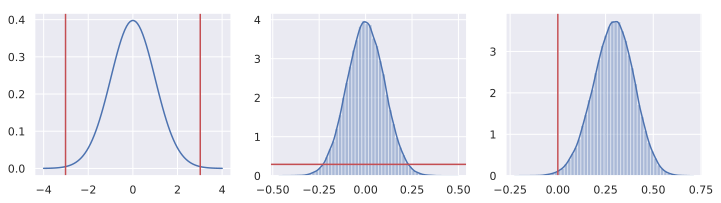

In [406]:
r = pearson_corr(X, Y)
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

x = np.linspace(-4, 4, 100)
sns.lineplot(x, t.pdf(x, n - 2), ax=ax[0])
ax[0].axvline(x=T_student, c='r')
ax[0].axvline(x=- T_student, c='r')

sns.distplot(perm_distr, ax=ax[1])
ax[1].axhline(y=r, c='r')

sns.distplot(boot_distr, ax=ax[2])
ax[2].axvline(x=0, c='r');

**Выводы:**
Известно, что бутстреп является самым универсальным методом, но в сравнении с методами, созданными для конкретных задач, является менее мощным. В нашем случае первые два метода учитывают особенности статистики, которую мы вычисляем, и используют нулевое распределение этой статистики, поэтому они лучше подходят для решаемой задачи. Размер выборки достаточно большой, поэтому можно использовать центральную предельную теорему и применять критерий Стьюдента.

Эти рассуждения совпадают с результатами экспериментов: значение p-value для бутстрепа оказалось выше, чем для критерия Стьюдента и перестановочного теста. Значения достигаемого уровня значимости для этих двух критериев почти совпадают.

Все три критерия дают значение p-value < 0.05, поэтому нулевая гипотеза о равенстве корреляции нулю отвергается.

## Задача 2

Сравните две группы $S_1$ и $S_2$ размера $10 \times n$ по переменным $X_1, \dots, X_{10}$.

In [88]:
S1 = np.load("data2_1.npy")
S2 = np.load("data2_2.npy")

In [89]:
X_from_S1, X_from_S2 = S1[0], S2[0] # Test it

### U-тест Манна-Уиттни-Уилкоксона

U-Тест проверяет нулевую гипотезы о том, что с равной вероятностью случайно выбранное значение из одной совокупности будет меньше или больше случайно выбранного значения из второй совокупности. 

Статистика U-теста эквивалентна значению ROC-AUC: (https://en.wikipedia.org/wiki/Mann–Whitney_U_test).

В данной реализации вы можете не учитывать корректировку связанных рангов, а также использовать нормальное приближение и вычислять достигаемый уровень значимости через центральную предельную теорему. Для вычисления статистики можно пользоваться функцией `sp.stats.rankdata`. Тест должен быть _двусторонним_.

In [188]:
def mw_test(X_from_S1, X_from_S2):
    n1 = X_from_S1.shape[0]
    n2 = X_from_S2.shape[0]
    T = np.sum(sp.stats.rankdata(np.concatenate([X_from_S1, X_from_S2]))[:n1])
    mu = n1 * (n1 + n2 + 1) / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    p_val = 2 * min(norm.cdf(T, mu, sigma), 1 - norm.cdf(T, mu, sigma))
    return p_val

### Критерий однородности Колмогорова-Смирнова
Существует две версии критерия Колмогорова-Смирнова: одновыборочный (_согласия_) и двухвыборочный (_однородности_).

https://ru.wikipedia.org/wiki/Критерий_согласия_Колмогорова

Критерий _согласия_ Колмогорова предназначен для проверки гипотезы о принадлежности выборки некоторому закону распределения, то есть проверки того, что эмпирическое распределение соответствует предполагаемой модели.

Критерий _однородности_ Смирнова используется для проверки гипотезы о принадлежности двух независимых выборок одному закону распределения, то есть о том, что два эмпирических распределения соответствуют одному и тому же закону.

**Замечание**. Написать векторный вариант этой функции может быть непросто, и вы можете посмотреть исходные коды библиотеки `scipy` и попробовать написать свою интерпретацию метода.

* https://github.com/scipy/scipy/blob/v1.4.1/scipy/stats/mstats_basic.py#L1235-L1282
* https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3809
* https://github.com/scipy/scipy/blob/v1.4.1/scipy/stats/stats.py#L6087-L6282

In [178]:
def ks_test(X_from_S1, X_from_S2):
    n1 = X_from_S1.shape[0]
    n2 = X_from_S2.shape[0]
    x1_sorted = np.sort(X_from_S1)
    x2_sorted = np.sort(X_from_S2)
    x_full = np.concatenate([x1_sorted, x2_sorted])
    cdf1 = np.searchsorted(x1_sorted, x_full, side='right') / n1
    cdf2 = np.searchsorted(x2_sorted, x_full, side='right') / n2
    cdf_diff = cdf1 - cdf2
    D = np.max(np.abs(cdf_diff))
    prob = 1 - kstwobign.cdf(np.sqrt(n1 * n2 / (n1 + n2)) * D)     
    
    return prob

In [265]:
res = defaultdict(list)

for i, (X_from_S1, X_from_S2) in enumerate(zip(S1, S2)):
    res["X"].append(i+1)
    res["Mann–Whitney"].append(mw_test(X_from_S1, X_from_S2))
    res["Kolmogorov–Smirnov"].append(ks_test(X_from_S1, X_from_S2))
pd.DataFrame(res)

,X,Mann–Whitney,Kolmogorov–Smirnov
0,1,6.900047e-03,0.007992
1,2,8.468941e-01,0.998151
2,3,3.952950e-01,0.580618
3,4,2.520686e-01,0.000000
4,5,7.018682e-01,0.000000
5,6,8.149181e-01,0.000000
6,7,9.699321e-06,0.000445
7,8,2.238523e-07,0.000007
8,9,1.129567e-03,0.010084
9,10,4.318082e-01,0.010084


Выясните, какие переменные являются значимыми на уровне $\alpha$ с учётом коррекции.

In [182]:
alpha = 0.05

### Бонферрони


Простая коррекция _заданных_ уровней значимости: $ \alpha_1 = ... = \alpha_m = \alpha/m $. Альтернативный вид — переход к модифицированным _достигаемым_ уровням значимости: $\tilde{p}_i = \min(1, mp_i)$.

**Подсказка**. В программной реализации брать минимум не обязательно.

In [183]:
def bonferroni_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    alpha_new = alpha / p_vals.shape[0]
    is_rejected =  p_vals <= alpha_new
    return is_rejected

### Бонферрони-Холма

_Нисходящий_ метод множественной проверки гипотез:

$$\alpha_1 = \dfrac{\alpha}{m}, \alpha_2 = \dfrac{\alpha}{m - 1}, \ldots, \alpha_i = \dfrac{\alpha}{m - i + 1}, \ldots, \alpha_m = \alpha.$$

Тогда из вариационного ряда, если $p_{i} \ge \alpha_i$, принять все нулевые гипотезы $H_{(i)}, H_{(i+1)} \ldots H_{(m)}$ и остановиться; иначе отвергнуть $H_{(i)}$ и продолжить. Каждый _достигаемый_ уровень значимости $p_{(i)}$ сравнивается со своим _заданным_ уровнем значимости $\alpha_i$. 

Иначе, модифицированные _достигаемые_ значимости (p-values): $\tilde{p}_{(i)} = \min \Big( 1, \max \big ( (m - i + 1)p_{(i)}, \tilde{p}_{(i - 1)}\big ) \Big )$ сравниваются с исходным _заданным_ уровнем значимости $\alpha$.

**Подсказка**. Воспользуйтесь функкцией `np.maximum.accumulate`. Перейти от вариационного ряда $\tilde{p}_{(i)}$ к исходному $\tilde{p}_i$ можно с помощью обратной перестановки сортированных индексов. Несложно построить обратную перестановку, используя тождество $f^{-1}f = e$ (https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy?rq=1)

In [227]:
def holm_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    n = p_vals.shape[0]
    ind_sorted = np.argsort(p_vals)
    p_sorted = p_vals[ind_sorted]
    
    alpha_new = alpha / np.arange(n, 0, -1)
    
    is_rejected = (np.maximum.accumulate(p_sorted - alpha_new) <= 0)[np.argsort(ind_sorted)]
    
    return is_rejected

### Бенджамини-Хохберга

_Восходящий_ метод множественной проверки гипотез:

$$\alpha_1 = \dfrac{\alpha}{m}, \alpha_2 = \dfrac{2\alpha}{m}, \ldots, \alpha_i = \dfrac{i\alpha}{m}, \ldots, \alpha_m = \alpha.$$

Тогда из вариационного ряда, если $p_{i} \le \alpha_i$, отвергнуть все нулевые гипотезы $H_{(1)}, H_{(2)} \ldots H_{(i)}$ и остановиться; иначе принять $H_{(i)}$ и продолжить. Каждый _достигаемый_ уровень значимости $p_{(i)}$ сравнивается со своим _заданным_ уровнем значимости $\alpha_i$. 

Иначе, модифицированные _достигаемые_ значимости (p-values): $\tilde{p}_{(i)} = \min \big( 1,  \dfrac{mp_{(i)}}{i}, \tilde{p}_{(i + 1)} \big )$ сравниваются с исходным _заданным_ уровнем значимости $\alpha$.

**Подсказка**. `np.minimum.accumulate` и `[::-1]`

In [246]:
def bendjamini_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    n = p_vals.shape[0]
    ind_sorted = np.argsort(p_vals)[::-1]
    p_sorted = p_vals[ind_sorted]
    
    alpha_new = np.arange(n, 0, -1) * alpha / n
    
    is_rejected = (np.minimum.accumulate(p_sorted - alpha_new) < 0)[np.argsort(ind_sorted)]
    return is_rejected

In [247]:
bendjamini_correction(np.array(res["Mann–Whitney"]), alpha)


array([ True, False, False, False, False, False,  True,  True,  True,
       False])

Сравните результаты и сделайте выводы. Проверьте корректность вычислений сравнив значения с библиотечной функцией `statsmodels.stats.multitest.multipletests`.

In [268]:
res["no_corr_mw"] = np.array(res["Mann–Whitney"]) < alpha
res["bonf_corr_mw"] = bonferroni_correction(np.array(res["Mann–Whitney"]), alpha)
res["holm_corr_mw"] = holm_correction(np.array(res["Mann–Whitney"]), alpha)
res['bendj_corr_mw'] = bendjamini_correction(np.array(res["Mann–Whitney"]), alpha)

res["no_corr_ks"] = np.array(res["Kolmogorov–Smirnov"]) < alpha
res["bonf_corr_ks"] = bonferroni_correction(np.array(res["Kolmogorov–Smirnov"]), alpha)
res["holm_corr_ks"] = holm_correction(np.array(res["Kolmogorov–Smirnov"]), alpha)
res['bendj_corr_ks'] = bendjamini_correction(np.array(res["Kolmogorov–Smirnov"]), alpha)

In [269]:
pd.DataFrame(res)

,X,Mann–Whitney,Kolmogorov–Smirnov,no_corr_mw,bonf_corr_mw,holm_corr_mw,bendj_corr_mw,no_corr_ks,bonf_corr_ks,holm_corr_ks,bendj_corr_ks
0,1,6.900047e-03,0.007992,True,False,True,True,True,False,True,True
1,2,8.468941e-01,0.998151,False,False,False,False,False,False,False,False
2,3,3.952950e-01,0.580618,False,False,False,False,False,False,False,False
3,4,2.520686e-01,0.000000,False,False,False,False,True,True,True,True
4,5,7.018682e-01,0.000000,False,False,False,False,True,True,True,True
5,6,8.149181e-01,0.000000,False,False,False,False,True,True,True,True
6,7,9.699321e-06,0.000445,True,True,True,True,True,True,True,True
7,8,2.238523e-07,0.000007,True,True,True,True,True,True,True,True
8,9,1.129567e-03,0.010084,True,True,True,True,True,False,True,True
9,10,4.318082e-01,0.010084,False,False,False,False,True,False,True,True


В обозначениях таблицы True соответствует отвергнутым нулевым гипотезам, False - если нет оснований для отвержения.

*Дополнительная информация:* на самом деле лишь переменные $X_1$, $X_2$ и $X_3$ имеют одинаковое распределение.

Не забудьте сделать выводы!

**Выводы:**

Согласно теории, критерий Манна-Уитни является состоятельным в случае, когда распределения совпадают с точностью до сдвига, то есть когда $H0: F_1(x) = F_2(x)$ проверяется против альтернативной гипотезы $H1: F_1(x) = F_2(x + \delta x)$, но не является состоятельным против общей альтернативы $H1: F_1(x) \neq F_2(x)$, где $F_1(x), F_2(x)$ - функции распределения выборок. Это значит, что условии верности альтернативной гипотезы вероятность отвергнуть нулевую гипотезу не стремится к 1 с увеличением размера выборки. То есть при сильном различии поведения функций распределения мы чаще, чем нужно, не будем отвергать нулевую гипотезу, то есть будем допускать ошибки 2-го рода. 

Теоретические сведения совпадают с результатами экспериментов: критерий Манна-Уитни, даже без учета коррекций, не отвергает многие из нулевых гипотез, хотя они неверны. Например, для переменной X5 достигаемый уровень значимости оказался относительно большим, хотя, как видно на графике ниже, гистограммы выглядят совсем по-разному. Думаю, дело в том, что гистограммы симметричны, и оси их симметрии совпадают. Так как критерий ранговый, то при его применении мы теряем много информации об исходных значениях объектов выборки.

Критерий Колмогорова-Смирнова не обладает такими недостатками. Известно, что асимптотическая мощность критерия равна 1. Его высокая мощность подтверждается экспериментами: без учета коррекций, а также с учетом коррекций Бонферрони-Xолма и Бенджамини-Хохберга с помощью критерия удается отвергнуть все неверные нулевые гипотезы.

В результатах экспериментов для этих двух критериев без коррекции возникла ошибка 1-го рода: для переменной X1 верная нулевая гипотеза была ошибочно отвергнута. Если посмотреть на гистограммы выборок значений этой переменной для двух групп S1 и S2 (гистограммы приведены ниже), то можно попытаться предположить, почему статистики критериев получились такими маловероятными при условии верности гипотезы H0. Гистограмма группы S1 (синяя на графике) сильнее смещена вправо, чем гистограмма группы S2. Возможно, поэтому достигаемый уровень значимости для критерия Манна-Уитни оказался небольшим. Критерий Колмогорова-Смирнова при подсчете статистики учитывает только максимальный модуль разности в точке между эмпирическими функциями распределения выборок. Ниже приведены графики этих функций распределения, и можно видеть, что на некоторых участках модуль разности между их значениями достаточно большой. Для сравнения ниже приведены такие же графики для переменных X2 и X3, для которых достигаемый уровень значимости критерия Колмогорова-Смирнова оказался большим. Можно видеть, что их выборочные функции распределения почти совпадают.

Таким образом, возникновение этой ошибки можно объяснить тем, что вероятность получить такие выборки из одной и той же генеральной совокупности очень мала. Но даже очень редкие события иногда происходят.

Применение критериев без учета коррекции приводит к тому, что вероятность ошибки 1-го рода в десяти экспериментах оказывается выше, чем $\alpha$. Применение поправок на множественную проверку гипотез позволяет контролировать на уровне alpha какие-то величины, описывающие вероятность совершения ошибок 1-го рода в совокупности экспериментов.

Методы Бонферрони и Бонферрони-Холма позволяют контролировать величину $FWER = P(V > 0)$ на уровне $\alpha$, где V - суммарное число ошибок 1-го рода для всех экспериментов. В методе Бонферрони оценка для этой вероятности слишком завышенная, то есть в итоге гарантируется значение $FWER$ намного ниже, чем $\alpha$, что приводит к большому числу ошибок 2-го рода. Это подтверждается экспериментами. Но в то же время поправка Бонферрони позволяет не отвергнуть правильную нулевую гипотезу для переменной $X1$.

Метод Бонферрони-Холма также обеспечивает $FWER \leq \alpha$, но теперь оценка более точная, и число ошибок 2-го рода снижается. Это также видно в экспериментах: применение поправки Бонферрони к критерию Колмогорова-Смирнова приводит к тому, что не отвергается нулевая гипотеза для переменных X9 и X10, а применение поправки Бонферрони-Холма позволяет правильно отвергнуть эти гипотезы. Но вместе с тем отвергается и верная нулевая гипотеза для переменной $X1$.

Метод Бенджамини-Хохберга позволяет контролировать на уровне $\alpha$ другую величину $FDR = \mathbb{E}(\frac{V} {max(R, 1)})$, где V - количество ошибок 1-го рода, R - общее количество отвергнутых нулевых гипотез. Таким образом, такая коррекция позволяет совершить некоторое небольшое количество ошибок 1-го рода, но за счет этого отвергнуть больше неверных нулевых гипотез и уменьшить число ошибок 2-го рода. В наших экспериментах результаты применения этого метода не отличаются от результатов применения метода Бонферрони-Холма, но, я думаю, если бы экспериментов было значительно больше десяти, то разница была бы видна.

Я думаю, что тот факт, что метод Бонферрони не отвергает нулевую гипотезу для $X1$, а два других метода отвергают, говорит о том, что получение таких выборок из одной генеральной совокупности настолько маловероятно, что для того чтобы не отвергнуть нулевую гипотезу, нужно уменьшить уровень значимости $\alpha$. В методе Бонферрони мы как раз, фактически, обеспечиваем $\alpha$ намного ниже требуемого, потому гипотеза и не отвергается.

In [363]:
def plot(ind):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.distplot(S1[ind - 1], bins=20, color='r', label='S1', ax=ax[0])
    sns.distplot(S2[ind - 1], bins=20, color='b', label='S2', ax=ax[0])
    ax[0].legend()

    sns.kdeplot(S1[ind - 1], cumulative=True, shade=True, label='S1', color='r', ax=ax[1])
    sns.kdeplot(S2[ind - 1], cumulative=True, shade=True, label='S2', color='b', ax=ax[1])
    ax[1].legend()

    fig.suptitle('X' + str(ind));

Для X1 достигаемый уровень значимости низкий для обоих критериев. 

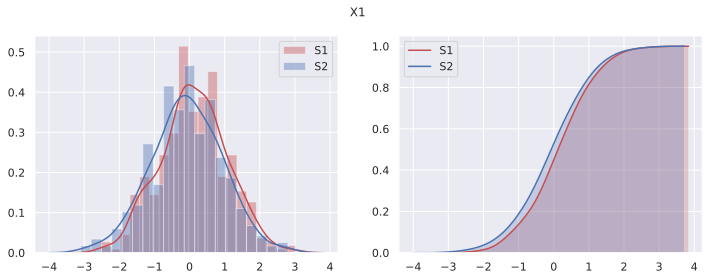

In [365]:
plot(1)

Для X2 достигаемый уровень значимости высокий для обоих критериев. 

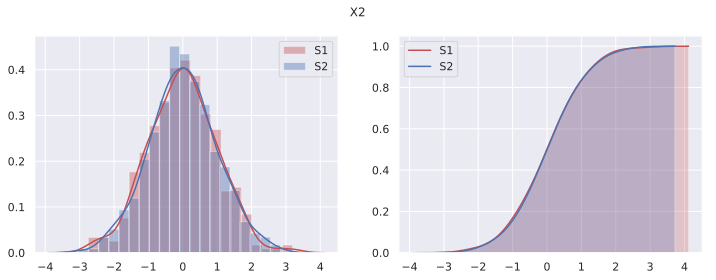

In [366]:
plot(2)

Для X3 достигаемый уровень значимости высокий для обоих критериев. 

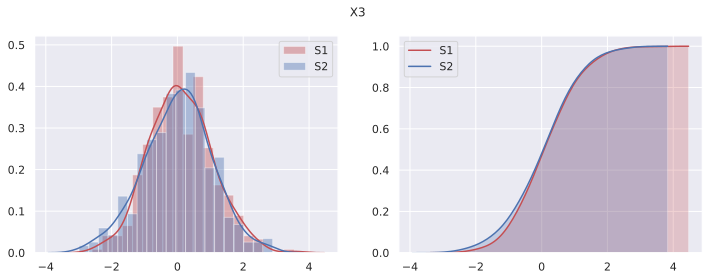

In [367]:
plot(3)

Для X5 достигаемый уровень значимости высокий для критерия Манна-Уитни (примерно равен значению этого критерия для переменных X2 и X3), низкий для критерия Колмогорова-Смирнова 

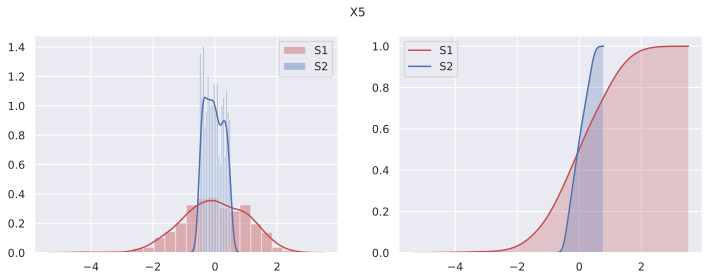

In [368]:
plot(5)

Для X9 значение критерия Колмогорова-Смирнова примерно равно значению этого критерия для X1.

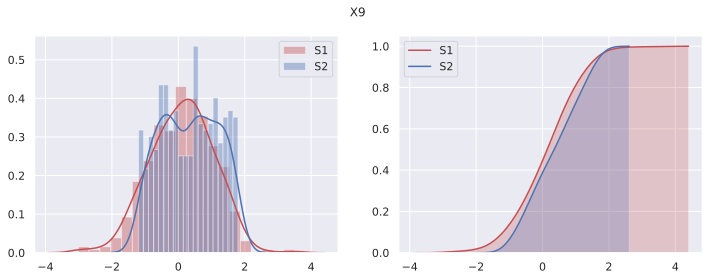

In [370]:
plot(9)

Для X10 значение критерия Колмогорова-Смирнова примерно равно значению этого критерия для X1.

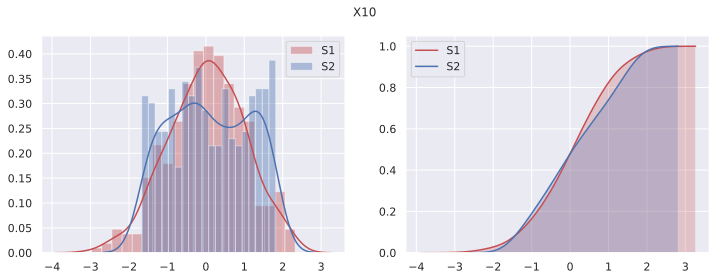

In [371]:
plot(10)